# Import Libraries

In [5]:
import os
import PIL
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Unzip Dataset Files

In [6]:
!unzip archive.zip

Archive:  archive.zip
  inflating: dataset/Beagle/Beagle_1.jpg  
  inflating: dataset/Beagle/Beagle_10.jpg  
  inflating: dataset/Beagle/Beagle_100.jpg  
  inflating: dataset/Beagle/Beagle_11.jpg  
  inflating: dataset/Beagle/Beagle_12.jpg  
  inflating: dataset/Beagle/Beagle_13.jpg  
  inflating: dataset/Beagle/Beagle_14.jpg  
  inflating: dataset/Beagle/Beagle_15.jpg  
  inflating: dataset/Beagle/Beagle_16.jpg  
  inflating: dataset/Beagle/Beagle_17.jpg  
  inflating: dataset/Beagle/Beagle_18.jpg  
  inflating: dataset/Beagle/Beagle_19.jpg  
  inflating: dataset/Beagle/Beagle_2.jpg  
  inflating: dataset/Beagle/Beagle_20.jpg  
  inflating: dataset/Beagle/Beagle_21.jpg  
  inflating: dataset/Beagle/Beagle_22.jpg  
  inflating: dataset/Beagle/Beagle_23.jpg  
  inflating: dataset/Beagle/Beagle_24.jpg  
  inflating: dataset/Beagle/Beagle_25.jpg  
  inflating: dataset/Beagle/Beagle_26.jpg  
  inflating: dataset/Beagle/Beagle_27.jpg  
  inflating: dataset/Beagle/Beagle_28.jpg  
  inflating

# Load Class Names


In [7]:
class_names = sorted(os.listdir('dataset'))
class_ids = {label: i for i, label in enumerate(class_names)}
class_ids

{'Beagle': 0,
 'Boxer': 1,
 'Bulldog': 2,
 'Dachshund': 3,
 'German_Shepherd': 4,
 'Golden_Retriever': 5,
 'Labrador_Retriever': 6,
 'Poodle': 7,
 'Rottweiler': 8,
 'Yorkshire_Terrier': 9}

# Load & Display Image

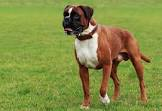

In [8]:
image_filepath = 'dataset/Boxer/Boxer_1.jpg'
image = PIL.Image.open(image_filepath)
image

# Load & Preprocess Images

In [9]:
image_size = (64, 64)

inputs = []
targets = []
for label in class_names:
    for filename in os.listdir(f'dataset/{label}'):
        filepath = f'dataset/{label}/{filename}'
        img = PIL.Image.open(filepath).convert('RGB').resize(image_size)
        inputs.append(img)
        targets.append(class_ids[label])
inputs = np.float32(inputs)
targets = np.int32(targets)

inputs.shape, targets.shape

((967, 64, 64, 3), (967,))

# Plot Target Distribution

<BarContainer object of 10 artists>

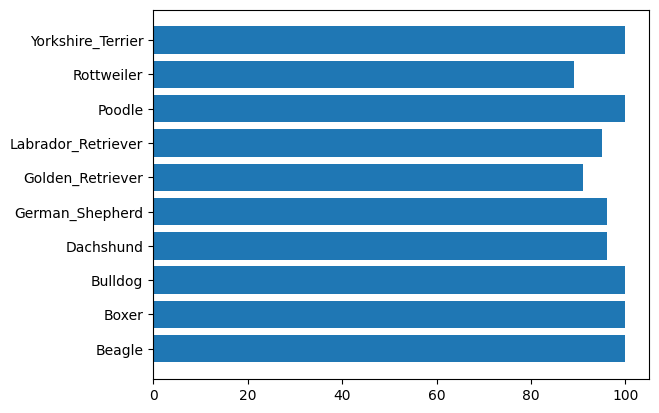

In [10]:
target_counts = np.unique(targets, return_counts=True)
plt.barh(class_names, target_counts[1])

# Setting Seeds To Enable Reproducability

In [11]:
seed = 0

tf.random.set_seed(seed=seed)
np.random.seed(seed=seed)
random.seed(seed)

# Split Inputs into Train-Test with Stratify Option

In [12]:
test_size = 0.3
stratify = [targets.shape]

x_train, x_test, y_train, y_test = train_test_split(
    inputs,
    targets,
    test_size=0.3,
    stratify=targets,
    random_state=seed
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((676, 64, 64, 3), (676,), (291, 64, 64, 3), (291,))

# Preprocessing Dataset

In [13]:
x_train /= 255.0
x_test /= 255.0
y_train = np.eye(len(class_names))[y_train]
y_test = np.eye(len(class_names))[y_test]

y_train.shape, y_test.shape

((676, 10), (291, 10))

# Building Multi-Layer Perceptron


In [14]:
input_size = x_train.shape[1:]
output_size = len(class_names)

mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='MLP')
mlp.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,794 (6.07 MB)

 Trainable params: 1,590,794 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

# Training Neural Network

* Optimizer: Adam
* Learning Rate: 0.001
* Loss Function: Categorical Cross-Entropy
* Metrics: Accuracy
* Batch Size: 32
* Epochs: 30

In [15]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
mlp.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
batch_size = 32
epochs = 30

history = mlp.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.0999 - loss: 4.0747 - val_accuracy: 0.1959 - val_loss: 2.3507
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1825 - loss: 2.2251 - val_accuracy: 0.2096 - val_loss: 2.0770
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3036 - loss: 1.9936 - val_accuracy: 0.3471 - val_loss: 1.9164
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4048 - loss: 1.7670 - val_accuracy: 0.4089 - val_loss: 1.7360
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5082 - loss: 1.5404 - val_accuracy: 0.4296 - val_loss: 1.6256
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5672 - loss: 1.3575 - val_accuracy: 0.4570 - val_loss: 1.4757
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6385 - loss: 1.1375 - val_accuracy: 0.5464 - val_loss: 1.3770
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7316 - loss: 0.9754 - val_accuracy: 0.5945 - val_loss

# Evaluating Model Performance Per Epoch


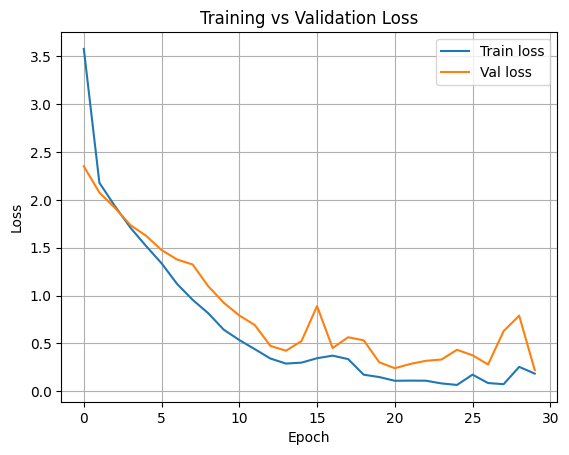

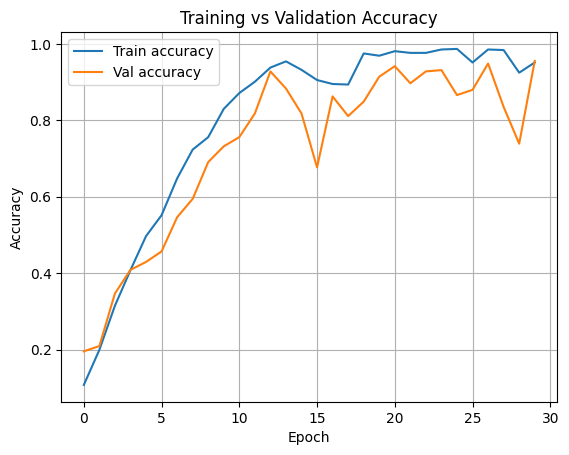

In [17]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Building Convolutional Neural Network

In [18]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', use_bias=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', use_bias=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='CNN')
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 31, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,298 (13.18 MB)

 Trainable params: 3,456,298 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

# Training CNN

In [19]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.1046 - loss: 2.4699 - val_accuracy: 0.3677 - val_loss: 2.2155
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4118 - loss: 2.0326 - val_accuracy: 0.5430 - val_loss: 1.6547
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6681 - loss: 1.2251 - val_accuracy: 0.7766 - val_loss: 0.9956
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8773 - loss: 0.5613 - val_accuracy: 0.8866 - val_loss: 0.4375
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9775 - loss: 0.1703 - val_accuracy: 0.9656 - val_loss: 0.2620
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9903 - loss: 0.0759 - val_accuracy: 0.9759 - val_loss: 0.1276
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9885 - loss: 0.0527 - val_accuracy: 0.9794 - val_loss: 0.1146
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 0.9897 - val_los

# Evaluating Model Performance Per Epoch

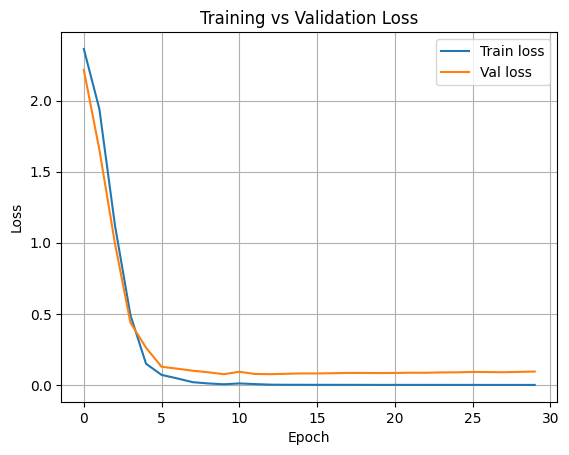

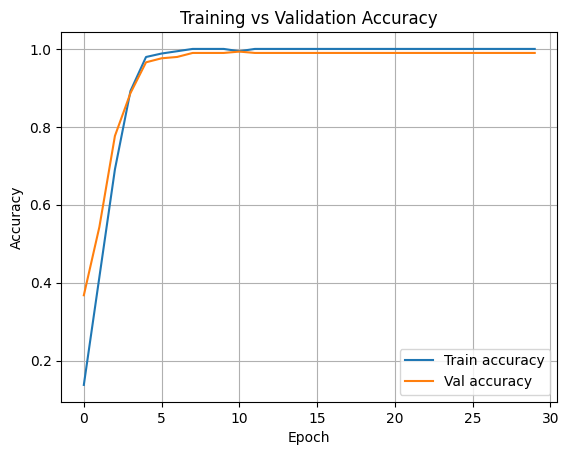

In [20]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# MLP vs CNN comparison

Το CNN αποδίδει καλύτερα από το ML. Αυτό συμβαίνει καθώς στο CNN, το μοντέλο κοιτάει μικρές περιοχές της εικόνας και μαθαίνει βασικά χαρακτηριστικά, όπως γραμμές, γωνίες και σχήματα. Στη συνέχεια, αυτά τα απλά χαρακτηριστικά συνδυάζονται και σχηματίζουν πιο σύνθετες πληροφορίες, όπως μέρη ενός σκύλου (μάτια, αυτιά, μουσούδα). Έτσι, το CNN μπορεί να αναγνωρίσει πιο εύκολα τo είδος του σκύλου, ακόμη κι αν η εικόνα έχει μικρές διαφορές. Αντίθετα, το MLP μετατρέπει πρώτα την εικόνα σε μία μεγάλη λίστα αριθμών. Με αυτόν τον τρόπο χάνεται η δομή της εικόνας, δηλαδή το ποιο pixel είναι δίπλα σε ποιο. Έτσι Το MLP βλέπει όλα τα pixel ανεξάρτητα μεταξύ τους και δεν μπορεί εύκολα να καταλάβει σχήματα.

# Building CΝΝ with using Batch Normalization

In [24]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', use_bias=True),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', use_bias=True),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='CNN')
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     6,889,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,910,666 (26.36 MB)

 Trainable params: 6,910,474 (26.36 MB)

 Non-trainable params: 192 (768.00 B)

# Evaluating Model Performance Per Epoch

In [25]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.4426 - loss: 5.5901 - val_accuracy: 0.2440 - val_loss: 2.1627
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9613 - loss: 0.1970 - val_accuracy: 0.2715 - val_loss: 2.1699
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9964 - loss: 0.0123 - val_accuracy: 0.3505 - val_loss: 2.2148
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9965 - loss: 0.0075 - val_accuracy: 0.2302 - val_loss: 2.7237
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.2509 - val_loss: 2.6897
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.6051e-04 - val_accuracy: 0.2543 - val_loss: 2.8456
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 3.4808e-05 - val_accuracy: 0.2680 - val_loss: 2.9738
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.0455e-05 - val_accurac

# Evaluating Model Performance Per Epoch

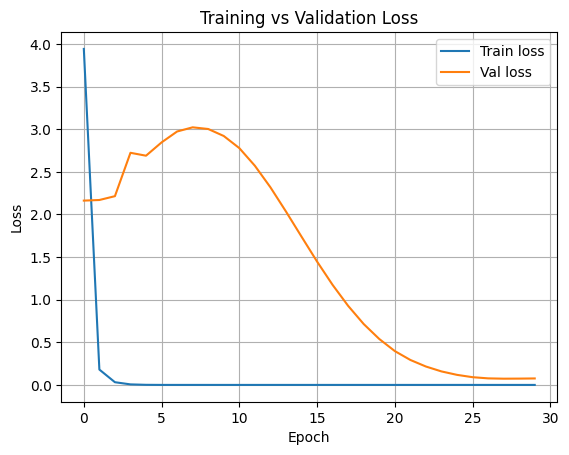

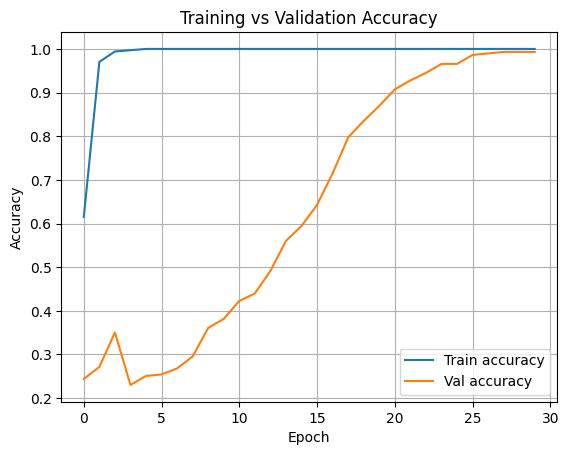

In [26]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Η χρήση Batch Normalization προκαλεί αρχική αστάθεια στα δεδομένα επικύρωσης, ωστόσο γρήγορα οδηγεί σε πιο σταθερή εκπαίδευση και μετά από αρκετά epochs και σε καλύτερη γενίκευση του μοντέλου.